In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('drive/MyDrive/Books/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [3]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.Sentiment.unique()

array([0, 4])

In [5]:
df['Sentiment'] = df.Sentiment.replace(4,1)

<Axes: xlabel='Sentiment', ylabel='count'>

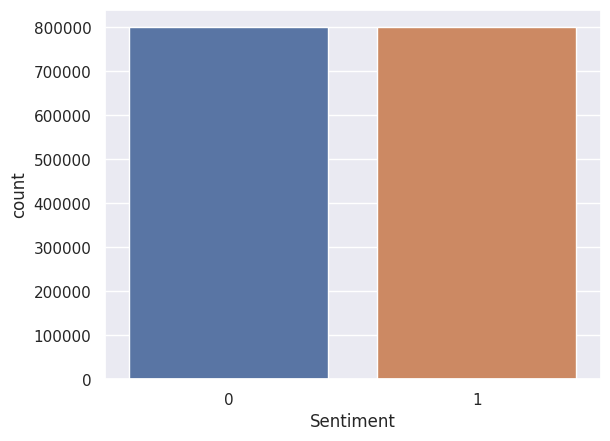

In [6]:
sns.countplot(x=df['Sentiment'])

In [7]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [8]:
df['Tweet'] = df.Tweet.apply(process_text)

In [9]:
df.head()

,Sentiment,Tweet
0,0,"entity - awww, that's a bummer. you shoulda ..."
1,0,is upset that he can't update his facebook by ...
2,0,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"entity no, it's not behaving at all. i'm mad. ..."


In [10]:
labels = df.Sentiment.values
text = df.Tweet.values

In [15]:
!pip install transformers
!pip install torch
!pip install rjieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.0 MB/s eta 0:00:00


In [13]:
from transformers import RoFormerTokenizer,AdamW,RoFormerForSequenceClassification

In [16]:
tokenizer = RoFormerTokenizer.from_pretrained("junnyu/roformer_chinese_base",do_lower_case = True)

In [17]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [19]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1280000
Validation Size -  320000


In [20]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)

In [21]:
len(train_dl),len(val_dl)

(40000, 10000)

In [23]:
model = RoFormerForSequenceClassification.from_pretrained(
    "junnyu/roformer_chinese_base",
    num_labels=2,
output_attentions = False,
output_hidden_states = False)

Some weights of the model checkpoint at junnyu/roformer_chinese_base were not used when initializing RoFormerForSequenceClassification: ['cls.predictions.decoder.weight', 'roformer.pooler.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'roformer.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing RoFormerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RoFormerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [24]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [26]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [28]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [29]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [30]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3781561668191105
Validation loss: 0.3424458754774183
Accuracy: 0.852346875


In [31]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [32]:
from transformers import RoFormerTokenizer,RoFormerForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading RoFormer tokenizer...')
output_dir = './'
tokenizer = RoFormerTokenizer.from_pretrained(output_dir)
model_loaded = RoFormerForSequenceClassification.from_pretrained(output_dir)

Loading RoFormer tokenizer...


In [35]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = RoFormerTokenizer.from_pretrained(output_dir)
    model_loaded = RoFormerForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [36]:
ans = Sentiment('i want to die')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative
